# Creating Dataset object and visualizing inputs

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm_notebook
from PIL import Image
from torch.utils.data import Dataset, random_split, DataLoader
import os
import copy
import seaborn as sns

In [0]:
rm -d ./images

In [0]:
!unzip images_full.zip

Archive:  images_full.zip
  inflating: images/1001524.jpg      
  inflating: images/1001804.jpg      
  inflating: images/1003035.jpg      
  inflating: images/1004028.jpg      
  inflating: images/1004054.jpg      
  inflating: images/1005343.jpg      
  inflating: images/1007700.jpg      
 extracting: images/1008439.jpg      
  inflating: images/1010906.jpg      
  inflating: images/1011369.jpg      
  inflating: images/1011813.jpg      
  inflating: images/1013663.jpg      
  inflating: images/1014573.jpg      
  inflating: images/1015027.jpg      
  inflating: images/1016682.jpg      
  inflating: images/1016683.jpg      
  inflating: images/1019271.jpg      
 extracting: images/1048999.jpg      
  inflating: images/1049854.jpg      
  inflating: images/1051155.jpg      
  inflating: images/1056547.jpg      
  inflating: images/1056555.jpg      
  inflating: images/1059245.jpg      
 extracting: images/1062001.jpg      
 extracting: images/1062006.jpg      
  inflating: images/1069

In [0]:
rm -rf test_images/

In [0]:
!mkdir test_images

In [0]:
test_data = pd.read_csv('test.csv')
test_data.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [0]:
import shutil
for file in test_data['image']:
  #print(file)
  shutil.move('./images/'+file, './test_images/'+file)

In [0]:
! ls -lrt images/* | wc -l

6252


In [0]:
data = pd.read_csv('./train.csv')
data.head()

,image,category
0,2823080.jpg,1
1,2870024.jpg,1
2,2662125.jpg,2
3,2900420.jpg,3
4,2804883.jpg,2


In [0]:
np.array(data.loc[data['image']=='2804883.jpg']['category'])[0]

2

In [0]:
class Shiploader(Dataset):
  def __init__(self, root_dir, csv_file=None,  train=True, transform=None):
    self.file_path = root_dir
    self.csv_file = csv_file
    self.file_names = [file for _,_,files in os.walk(self.file_path) for file in files]
    self.len = len(self.file_names)
    self.transform = transform
    self.csv_file = csv_file
    self.train = train
    
    if(self.csv_file):
      self.image_data = pd.read_csv(self.csv_file)
      #print(self.image_data.head())
        
    
  def __len__(self):
    return(len(self.file_names))
  
  def __getitem__(self, idx):
    file_name = self.file_names[idx]
    img = self.pil_loader(self.file_path+'/'+file_name)
    if(self.transform):
      img = self.transform(img)
    
    if(self.train):
      #print(file_name)
      #print(np.array(self.image_data.loc[self.image_data['image']==str(file_name)]['category']))
      category = np.array(self.image_data.loc[self.image_data['image']==str(file_name)]['category'])[0]
      category -= 1
      #print(img.shape)
      return img, category
    
    else:
      return img, file_name
    
  
  def pil_loader(self, file):
    img = Image.open(file).convert('RGB')
    #img = img.convert('rgb')
    return img

In [0]:
transform = torchvision.transforms.Compose([torchvision.transforms.RandomResizedCrop((128,128)),
                                            torchvision.transforms.ToTensor()
                                           ])

In [0]:
full_data = Shiploader('./images/',csv_file='./train.csv',train=True, transform=transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

In [0]:
test_data = Shiploader('./test_images', train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=72, shuffle=False)

In [0]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
images, cats = next(iter(trainloader))
print(images.shape)
print(cats)

torch.Size([1, 3, 128, 128])
tensor([3])


In [0]:
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle=True)
images, cats = next(iter(testloader))
print(images.shape)
print(cats)

torch.Size([4, 3, 128, 128])
('2790506.jpg', '2839544.jpg', '2876185.jpg', '1721331.jpg')


In [0]:
train_data.dataset.len

6252

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=4, shuffle=True)

In [0]:

def imshow(img, title):
    np_img = img.numpy()
    plt.figure()
    plt.axis('off')
    plt.imshow(np.transpose(np_img, (1,2,0)))
    plt.title(title)
    plt.show()

def show_image_batches(data_loader):
    img, labels = next(iter(data_loader))
    img = torchvision.utils.make_grid(img)
    title = [str(label.item()) for label in labels]
    imshow(img, title)
    

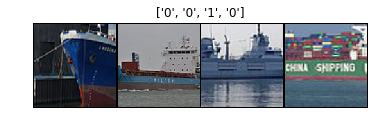

In [0]:
show_image_batches(train_loader)

# My Own Conv Net

In [0]:
class LeNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn_model = nn.Sequential(
                     nn.Conv2d(3, 6, 5), #(N,3,224,224) -> (N,6,220,220)
                     nn.BatchNorm2d(6),
                     nn.ReLU(),
                     nn.AvgPool2d(2, stride=2), #(N,6,110,110)
                     nn.Conv2d(6, 16, 5), #(N,16,106,106)
                     nn.BatchNorm2d(16),
                     nn.ReLU(),
                     nn.AvgPool2d(2, stride=2), #(N,16,53,53)
                     nn.Conv2d(16, 24, 5)) #(N,24,49,49)
    
    
    self.fc_model = nn.Sequential(                  
                     nn.BatchNorm1d(57624),
                     nn.Linear(57624, 4096),
                     nn.ReLU(),
                     nn.Dropout(0.5),
                     nn.BatchNorm1d(4096),
                     nn.Linear(4096, 500),
                     nn.ReLU(),
                     nn.Dropout(0.5),
                     nn.BatchNorm1d(500),
                     nn.Linear(500, 5))
                     

    
  def forward(self, X):
    x = self.cnn_model(X)
    x = x.view(x.size(0), -1),
    x = self.fc_model(x)
    x+=1
    return(x)

In [0]:
class LeNet2(nn.Module):
  def __init__(self):
    super().__init__()
    
    self.cnn_model = nn.Sequential(
                      nn.Conv2d(3, 6, 5), #(N,3,224,224) -> (N,6,220,220)
                      nn.ReLU(),
                      nn.AvgPool2d(2, stride=2), #(N,6,110,110)
                      nn.Conv2d(6,16,5), #(N,16,106,106)
                      nn.ReLU(),
                      nn.AvgPool2d(2, stride=2)) #(N,16,53,53)
    
    self.fc_model = nn.Sequential(
                    nn.Linear(44944,4096),
                    nn.ReLU(),
                    nn.Linear(4096,400),
                    nn.ReLU(),
                    nn.Linear(400,5))
  
  def forward(self, X):
    x = self.cnn_model(X)
    #print(x.shape)
    x = x.view(x.size(0), -1)
    #print(x.shape)
    x = self.fc_model(x)
    #print(x.shape)
    #x += 1
    return(x)

In [0]:
mylenet = LeNet2()

In [0]:
batchsize=72
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batchsize, shuffle=True)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [0]:
print(torch.cuda.get_device_name())

Tesla T4


In [0]:
def evaluation(model):
  totals, correct = 0, 0
  model.eval()
  for data in validation_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, pred = torch.max(outputs.data, 1)
    totals += labels.size(0)
    correct += (pred == labels).sum().item()
    del images, labels
    torch.cuda.empty_cache()
  return(100*correct/totals)

In [0]:
print(device)

cuda:0


In [0]:

def train(epochs, lr, model, batchsize):
  
  loss_fn = nn.CrossEntropyLoss()
  n_iter = np.ceil(train_data.dataset.len // batchsize)
  max_acc = 0
  loss_arr=[]
  opt = optim.SGD(model.parameters(), lr=lr)
  for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
    
    for i, data in enumerate(train_loader, 0):
      images, labels = data
      #print(images.shape)
      #print(type(images), print(type(labels)))
      images, labels = images.to(device), labels.to(device)
      #print(type(images), print(type(labels)))
      model = model.to(device)
      #model.train()
      opt.zero_grad()
      outputs = model(images)
      #print(type(outputs))
      loss = loss_fn(outputs, labels)
      del images, labels
      torch.cuda.empty_cache()
      loss.backward()
      opt.step()
      
      if(i%25==0):
        print('Iter: %d/%d training loss:%0.3f'%(i,n_iter, loss.item()))
        
    loss_arr.append(loss.item())
    validation_acc = evaluation(model)
    
    print('Epoch: %d/%d Validation Accuracy: %0.3f' %(epoch, epochs, validation_acc))
    if(validation_acc > max_acc):
      model.eval()
      best_model = copy.deepcopy(model.state_dict())
      print('*******Max Accuracy encountered. Saving model!')
      max_acc = validation_acc
      model.train()
  plt.plot(loss_arr)
  plt.show()
  return(best_model)  
    

In [0]:
best_model = train(epochs=50,lr=0.01,model=mylenet, batchsize=batchsize)

# Models

In [0]:
vggnet = torchvision.models.vgg19_bn()

In [0]:
vggnet

In [0]:
mod_classifier = list(vggnet.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(in_features=4096, out_features=500, bias=True)])
mod_classifier.extend([nn.ReLU(inplace=True)])
mod_classifier.extend([nn.Dropout(p=0.5)])
mod_classifier.extend([nn.Linear(500,5, bias=True)])
vggnet.classifier = nn.Sequential(*mod_classifier)

In [0]:
vggnet.classifier = nn.Sequential(*mod_classifier)

In [0]:
print(vggnet)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3)

Iter: 0/86 training loss:1.639
Iter: 25/86 training loss:1.587
Iter: 50/86 training loss:1.694
Iter: 75/86 training loss:1.695
Epoch: 0/75 Validation Accuracy: 33.866
*******Max Accuracy encountered. Saving model!
Iter: 0/86 training loss:1.478
Iter: 25/86 training loss:1.578
Iter: 50/86 training loss:1.516
Iter: 75/86 training loss:1.543
Epoch: 1/75 Validation Accuracy: 25.240
Iter: 0/86 training loss:1.585
Iter: 25/86 training loss:1.443
Iter: 50/86 training loss:1.513
Iter: 75/86 training loss:1.403
Epoch: 2/75 Validation Accuracy: 34.665
*******Max Accuracy encountered. Saving model!
Iter: 0/86 training loss:1.453
Iter: 25/86 training loss:1.564
Iter: 50/86 training loss:1.445
Iter: 75/86 training loss:1.476
Epoch: 3/75 Validation Accuracy: 25.240
Iter: 0/86 training loss:2.149
Iter: 25/86 training loss:1.388
Iter: 50/86 training loss:1.432
Iter: 75/86 training loss:1.378
Epoch: 4/75 Validation Accuracy: 34.984
*******Max Accuracy encountered. Saving model!
Iter: 0/86 training loss

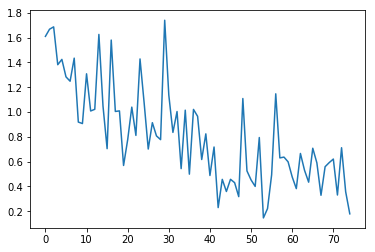

In [0]:
best_model = train(epochs=75, lr=0.01, model=vggnet, batchsize=72)

In [0]:
def predict(model, dataloader):
  predictions = []
  file_list = []
  submission = pd.DataFrame()
  model.eval()
  for data in dataloader:
    images, filenames = data
    images = images.to(device)
    model = model.to(device)
    outputs = model(images)
    _, preds = torch.max(outputs.data, 1)
    
    for i in preds:
      predictions.append(i.item())
    
    for i in filenames:
      file_list.append(i)
  submission['files'] = file_list
  submission['category'] = predictions
  return(submission)

In [0]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

In [0]:
submission = predict(vggnet, test_loader)

In [0]:
submission.head()

,files,category
0,2839566.jpg,0
1,2809762.jpg,1
2,2837617.jpg,0
3,2814829.jpg,4
4,1896150.jpg,3


In [0]:
submission.to_csv('submission1.csv')

In [0]:
test_df = pd.read_csv('test.csv')
test_df.head()

,image
0,1007700.jpg
1,1011369.jpg
2,1051155.jpg
3,1062001.jpg
4,1069397.jpg


In [0]:
final_sub = pd.DataFrame()
final_sub['image'] = test_df['image']
final_sub['category'] = 0
for i, file in enumerate(test_df['image'],0):
  cat = np.array(submission.loc[submission['files']==str(file)]['category'])[0]
  final_sub['image'][i] = str(file)
  final_sub['category'][i] = int(cat)+1
  
final_sub.head()  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,image,category
0,1007700.jpg,3
1,1011369.jpg,3
2,1051155.jpg,3
3,1062001.jpg,1
4,1069397.jpg,3


In [0]:
final_sub.to_csv('final_submission.csv', index=False)

# ResNet

In [0]:
resnet = torchvision.models.resnet18(pretrained=True)

In [0]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
mod_fc = nn.Sequential(nn.Linear(512,100, bias=True),
                       nn.ReLU(inplace=True),
                       nn.Dropout(0.5),
                       nn.Linear(100,50, bias=True),
                       nn.ReLU(inplace=True),
                       nn.Linear(50,5,bias=True))
                       

In [0]:
for param in resnet.parameters():
  param.requires_grad=False

In [0]:
resnet.fc = mod_fc

In [0]:
for param in resnet.parameters():
  if(param.requires_grad):
    print(param.shape)

torch.Size([100, 512])
torch.Size([100])
torch.Size([50, 100])
torch.Size([50])
torch.Size([5, 50])
torch.Size([5])


In [0]:
resnet

In [0]:
resnet_transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                                   torchvision.transforms.ToTensor(),
                                                   ])

In [0]:
full_data = Shiploader('./images/',csv_file='./train.csv',train=True, transform=resnet_transform)
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

In [0]:
batchsize=64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batchsize, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batchsize, shuffle=True)

In [0]:
images, cats = next(iter(train_loader))
print(images.shape, cats.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [0]:
test_data = Shiploader('./test_images', train=False, transform=resnet_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False)

Iter: 0/104 training loss:0.226
Iter: 50/104 training loss:0.180
Epoch: 0/50 Validation Accuracy: 82.907
*******Max Accuracy encountered. Saving model!
Iter: 0/104 training loss:0.305
Iter: 50/104 training loss:0.221
Epoch: 1/50 Validation Accuracy: 82.907
Iter: 0/104 training loss:0.174
Iter: 50/104 training loss:0.288
Epoch: 2/50 Validation Accuracy: 83.227
*******Max Accuracy encountered. Saving model!
Iter: 0/104 training loss:0.482
Iter: 50/104 training loss:0.550
Epoch: 3/50 Validation Accuracy: 83.067
Iter: 0/104 training loss:0.212
Iter: 50/104 training loss:0.211
Epoch: 4/50 Validation Accuracy: 83.067
Iter: 0/104 training loss:0.157
Iter: 50/104 training loss:0.136
Epoch: 5/50 Validation Accuracy: 83.706
*******Max Accuracy encountered. Saving model!
Iter: 0/104 training loss:0.391
Iter: 50/104 training loss:0.270
Epoch: 6/50 Validation Accuracy: 83.227
Iter: 0/104 training loss:0.249
Iter: 50/104 training loss:0.253
Epoch: 7/50 Validation Accuracy: 83.227
Iter: 0/104 trainin

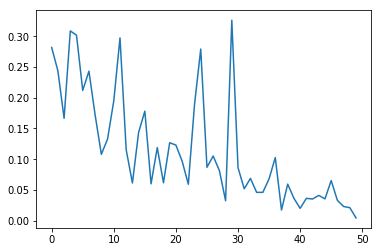

In [0]:
best_model = train(epochs=50, lr=0.01, model=resnet, batchsize=60)

In [0]:
type(best_model.values())

odict_values

In [0]:
resnet.load_state_dict(best_model.values())

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
submission = predict(resnet, test_loader)

In [0]:
del final_sub

In [0]:
final_sub = pd.DataFrame()
final_sub['image'] = test_df['image']
final_sub['category'] = 0
for i, file in enumerate(test_df['image'],0):
  cat = np.array(submission.loc[submission['files']==str(file)]['category'])[0]
  final_sub['image'][i] = str(file)
  final_sub['category'][i] = int(cat)+1
  
final_sub.head()  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,image,category
0,1007700.jpg,4
1,1011369.jpg,4
2,1051155.jpg,4
3,1062001.jpg,2
4,1069397.jpg,4


In [0]:
final_sub.to_csv('avship_sub2.csv')

#AlexNet

In [0]:
alexnet = torchvision.models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [0]:
for param in alexnet.parameters():
  param.requires_grad=False

In [0]:
mod_classifier = list(alexnet.classifier.children())[:-1]
mod_classifier.extend([nn.Linear(in_features=4096, out_features=500, bias=True)])
mod_classifier.extend([nn.ReLU(inplace=True)])
mod_classifier.extend([nn.Dropout(p=0.5)])
mod_classifier.extend([nn.Linear(500,5, bias=True)])
alexnet.classifier = nn.Sequential(*mod_classifier)

In [0]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

Iter: 0/97 training loss:1.602
Iter: 25/97 training loss:1.278
Iter: 50/97 training loss:1.017
Iter: 75/97 training loss:0.879
Epoch: 0/50 Validation Accuracy: 71.086
*******Max Accuracy encountered. Saving model!
Iter: 0/97 training loss:0.844
Iter: 25/97 training loss:0.726
Iter: 50/97 training loss:0.749
Iter: 75/97 training loss:0.746
Epoch: 1/50 Validation Accuracy: 73.482
*******Max Accuracy encountered. Saving model!
Iter: 0/97 training loss:0.861
Iter: 25/97 training loss:0.750
Iter: 50/97 training loss:0.747
Iter: 75/97 training loss:0.762
Epoch: 2/50 Validation Accuracy: 76.677
*******Max Accuracy encountered. Saving model!
Iter: 0/97 training loss:0.783
Iter: 25/97 training loss:0.717
Iter: 50/97 training loss:0.606
Iter: 75/97 training loss:0.749
Epoch: 3/50 Validation Accuracy: 69.489
Iter: 0/97 training loss:0.613
Iter: 25/97 training loss:0.538
Iter: 50/97 training loss:0.585
Iter: 75/97 training loss:0.613
Epoch: 4/50 Validation Accuracy: 76.677
Iter: 0/97 training loss

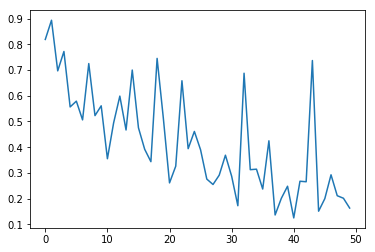

In [0]:
best_model = train(epochs=50, lr=0.01, model=alexnet, batchsize=64)

# Visualization

In [0]:
torch.zeros((5,5))

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [0]:
def occlusion(image, label, model, occ_size=50, occ_stride=50, occ_pixel=0.5):
  input_height = images.shape[-1]
  input_width = images.shape[-2]
  
  output_height = int(np.ceil((input_height - occ_size)/occ_stride))
  output_width = int(np.ceil((input_height - occ_size)/occ_stride))
  heatmap = torch.zeros((output_height, output_width))
  for h in range(0, input_height):
    for w in range(0, input_width):
      h_start = h*occ_stride
      h_end = min(input_height, h_start+occ_size)
      w_start = w*occ_stride
      w_end = min(input_width, w_start+occ_size)
      
      if(w_end >= input_width or h_end >= input_height):
        continue
      
      input_image = image.clone().detach()
      input_image[:,:,w_start:w_end,h_start:h_end] = occ_pixel
      
      input_image = input_image.to(device)
      output = model(input_image)
      output = nn.functional.softmax(output, dim=1)
      prob = output.tolist()[0][label]
      
      heatmap[h,w] = prob
  
  return(heatmap)
  

In [0]:
viz_loader = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=True)
image, label = next(iter(viz_loader))
print(image.shape, label.item())

torch.Size([1, 3, 128, 128]) 0


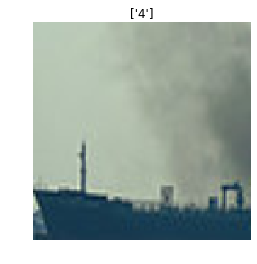

In [0]:
show_image_batches(viz_loader)

In [0]:
heatmap = occlusion(image, label.item(), vggnet, occ_size=32, occ_stride=14)

In [0]:
image = image.to(device)
output = vggnet(image)
prob = nn.functional.softmax(output, dim=1)
prob_no_occ, pred = torch.max(prob.data, 1)
print(prob_no_occ.item())
print(pred.item())

0.8081239461898804
0


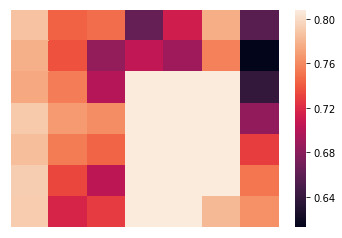

In [0]:
sns.heatmap(heatmap, xticklabels=False, yticklabels=False, vmax=prob_no_occ)